FICO Xpress v9.5.0, Hyper, solve started 19:11:06, Aug 25, 2025
Heap usage: 3256KB (peak 6633KB, 224KB system)
Maximizing QP noname using up to 8 threads and up to 15GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
       448 rows          800 cols         1527 elements
    164000 qobjelem
Presolved problem has:
       143 rows          360 cols          580 elements
      5800 qobjelem
Presolve finished in 0 seconds
Heap usage: 5867KB (peak 6633KB, 224KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.50e+06] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+06] / [ 1.39e+02,  1.50e+06]
  Objective      [min,max] : [ 1.31e-02,  7.54e-01] / [ 1.31e-02,  7.54e-01]
  Quadratic      [min,max] : [ 6.65e-13,  3.60e+06] / [ 1.01e-09,  3.50e-06]
Autoscaling applied standard scaling

Using AVX2 support
C

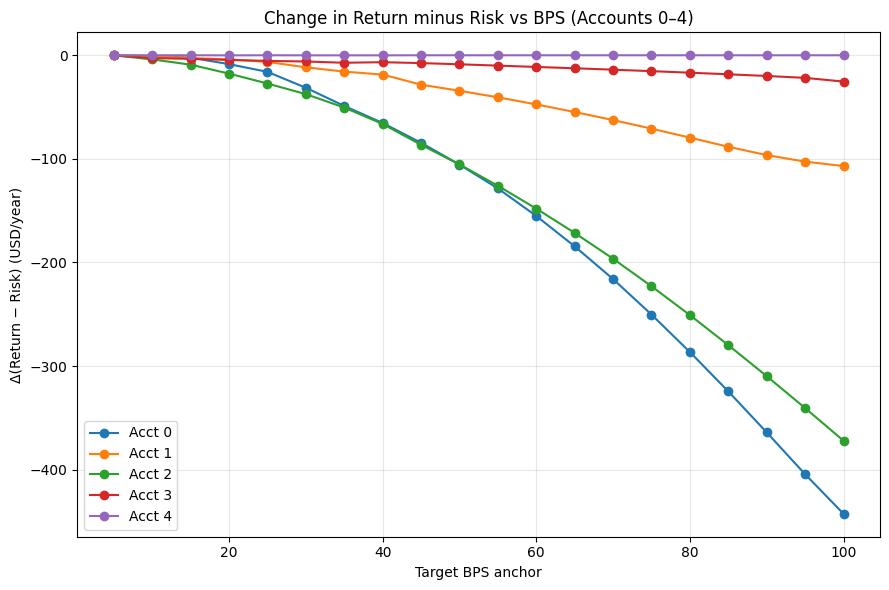

In [4]:
# --- ensure we always rescale from the unscaled/base Ω ---
try:
    Omega_plus_base
    Omega_minus_base
except NameError:
    Omega_plus_base  = Omega_plus.copy()
    Omega_minus_base = Omega_minus.copy()

# ---------- (1) helper: anchor Ω to target BPS (static check included) ----------
def scale_omegas_to_bps(Omega_plus_raw, Omega_minus_raw, Vbar, target_bps=100, xi=0.10):
    q0 = xi * np.asarray(Vbar, dtype=float)
    denom = max(q0.sum(), 1.0)
    c = target_bps / 1e4

    diag_p = np.diag(Omega_plus_raw)
    diag_m = np.diag(Omega_minus_raw)
    s0_p = 2 * c / np.maximum(diag_p * q0, 1e-30)
    s0_m = 2 * c / np.maximum(diag_m * q0, 1e-30)
    s0   = float(np.median(np.concatenate([s0_p, s0_m])))

    Op = s0 * Omega_plus_raw
    Om = s0 * Omega_minus_raw

    bps_plus  = 1e4 * 0.5 * (q0 @ Op @ q0) / denom
    bps_minus = 1e4 * 0.5 * (q0 @ Om @ q0) / denom
    bps_avg   = 0.5 * (bps_plus + bps_minus)

    sfix = target_bps / max(bps_avg, 1e-12)
    Op *= sfix
    Om *= sfix

    # re-check after sfix
    bps_plus  = 1e4 * 0.5 * (q0 @ Op @ q0) / denom
    bps_minus = 1e4 * 0.5 * (q0 @ Om @ q0) / denom
    bps_avg   = 0.5 * (bps_plus + bps_minus)

    return Op, Om, float(bps_plus), float(bps_minus), float(bps_avg)

# ---------- (2) solve once given Ω± ----------
def solve_model_once(Omega_plus_scaled, Omega_minus_scaled):
    # Modeling/Constraints/Goals
    model = xp.problem()
    w   = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
    wp  = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
    wm  = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
    wpc = [[model.addVariable(lb=0.0, ub=1.0)        for j in range(d)] for n in range(N)]

    for n in range(N):
        for j in range(d):
            model.addConstraint(wp[n][j] - wm[n][j] == w[n][j] - old_holdings[n, j])

    for n in range(N):
        model.addConstraint(xp.Sum(w[n][j] for j in range(d)) == budgets[n])
        for j in range(d):
            model.addConstraint(w[n][j] == budgets[n] * wpc[n][j])
        model.addConstraint(xp.Sum(wpc[n][j] for j in range(d)) == 1)

    # —— Section/Personalization Constraints——
    model.addConstraint(xp.Sum(w[0][j] for j in (sector_idxs["S"]+sector_idxs["H"])) >=  budgets[0]*0.40)
    model.addConstraint(xp.Sum(w[0][j] for j in (sector_idxs["T"]+sector_idxs["R"])) <=  budgets[0]*0.25)
    model.addConstraint(xp.Sum(w[1][j] for j in sector_idxs["T"]) >=  budgets[1]*0.40)
    model.addConstraint(xp.Sum(w[1][j] for j in (sector_idxs["C"] + [tickers.index("AMZN")])) >=  budgets[1]*0.30)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) >=  budgets[2]*0.10)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) <= budgets[2]*0.25)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) >= budgets[2]*0.10)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) <= budgets[2]*0.25)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) >= budgets[2]*0.10)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) <= budgets[2]*0.25)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) >= budgets[2]*0.10)
    model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) <= budgets[2]*0.25)
    model.addConstraint(xp.Sum(w[2][j] for j in (sector_idxs["S"]+sector_idxs["E"])) >= budgets[2]*0.05)
    model.addConstraint(xp.Sum(w[2][j] for j in (sector_idxs["S"]+sector_idxs["E"])) <= budgets[2]*0.15)
    model.addConstraint(xp.Sum(w[3][j] for j in (sector_idxs["S"]+sector_idxs["F"]+sector_idxs["E"])) >= budgets[3]*0.50)
    model.addConstraint(xp.Sum(w[3][j] for j in sector_idxs["F"]) >= budgets[3]*0.20)
    model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["E"]) >= budgets[4]*0.15)
    model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["F"]) >= budgets[4]*0.25)
    model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["T"]) >= budgets[5]*0.30)
    model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["H"]) >= budgets[5]*0.20)
    model.addConstraint(xp.Sum(w[5][j] for j in (sector_idxs["S"]+sector_idxs["R"])) <= budgets[5]*0.15)
    growth6 = sector_idxs["T"] + sector_idxs["C"] + sector_idxs["R"]
    model.addConstraint(xp.Sum(w[6][j] for j in growth6) <= budgets[6]*0.35)
    model.addConstraint(xp.Sum(w[6][j] for j in (sector_idxs["E"]+sector_idxs["F"]+sector_idxs["S"])) >= budgets[6]*0.40)
    model.addConstraint(xp.Sum(w[7][j] for j in [tickers.index("AMZN"), tickers.index("TSLA")]) >= budgets[7]*0.30)
    model.addConstraint(xp.Sum(w[7][j] for j in (sector_idxs["T"]+sector_idxs["F"]+sector_idxs["H"])) <= budgets[7]*0.50)
    growth8 = [tickers.index(t) for t in ["NVDA","TSLA","AAPL","MSFT"]]
    model.addConstraint(xp.Sum(w[8][j] for j in growth8) >= budgets[8]*0.50)
    model.addConstraint(xp.Sum(w[9][j] for j in (sector_idxs["S"]+sector_idxs["E"])) >= budgets[9]*0.20)
    model.addConstraint(xp.Sum(w[9][j] for j in (sector_idxs["T"]+sector_idxs["C"]+sector_idxs["R"])) >= budgets[9]*0.30)

    # objective 
    lin = xp.Sum(mu_list[n][j] * w[n][j] for n in range(N) for j in range(d))
    risk = xp.Sum(
        -0.5 * theta_list[n] * (budgets[n]**2) *
        xp.Sum(Sigma_list[n][i][j] * wpc[n][i] * wpc[n][j] for i in range(d) for j in range(d))
        for n in range(N)
    )
    T_plus  = [xp.Sum(tau[k, j] * wp[k][j]  for k in range(N)) for j in range(d)]
    T_minus = [xp.Sum(tau[k, j] * wm[k][j] for k in range(N)) for j in range(d)]
    quad_pp  = xp.Sum(T_plus[i]  * xp.Sum(Omega_plus_scaled[i,  j] * T_plus[j]  for j in range(d)) for i in range(d))
    quad_mm  = xp.Sum(T_minus[i] * xp.Sum(Omega_plus_scaled[i,  j] * T_minus[j] for j in range(d)) for i in range(d))
    cross_pm = xp.Sum(T_plus[i]  * xp.Sum(Omega_minus_scaled[i, j] * T_minus[j] for j in range(d)) for i in range(d))
    impact_pool = 0.5 * (quad_pp + quad_mm + 2 * cross_pm)

    impact_ind = 0
    for m in range(N):
        r_p = [(1 - tau[m, j]) * wp[m][j]  for j in range(d)]
        r_m = [(1 - tau[m, j]) * wm[m][j] for j in range(d)]
        qpp = xp.Sum(r_p[i] * xp.Sum(Omega_plus_scaled[i,  j] * r_p[j] for j in range(d)) for i in range(d))
        qmm = xp.Sum(r_m[i] * xp.Sum(Omega_plus_scaled[i,  j] * r_m[j] for j in range(d)) for i in range(d))
        cpm = xp.Sum(r_p[i] * xp.Sum(Omega_minus_scaled[i, j] * r_m[j] for j in range(d)) for i in range(d))
        impact_ind += 0.5 * (qpp + qmm + 2 * cpm)

    impact = - trading_days * (impact_pool + impact_ind)
    model.setObjective(lin + risk + impact, sense=xp.maximize)
    model.solve()

    # extract solutions
    W = np.zeros((N, d)); Wp = np.zeros((N, d)); Wm = np.zeros((N, d))
    for n in range(N):
        for j in range(d):
            W[n, j]  = model.getSolution(w[n][j])
            Wp[n, j] = model.getSolution(wp[n][j])
            Wm[n, j] = model.getSolution(wm[n][j])
    return W, Wp, Wm

# ---------- (3) sweep BPS; only track pre-cost utility changes (USD) ----------
bps_grid = list(range(5, 105, 5))   # 5,10,...,100
xi_anchor = 0.10

pre_cost_curves = {i: [] for i in range(5)}   # Absolute value of (Return - Risk) for accounts 0-4 (USD/year)
baseline_pre_cost = None                      # The absolute value of the first BPS (USD/year), used for printing tables

for idx, bps in enumerate(bps_grid):
    Op, Om, _, _, _ = scale_omegas_to_bps(Omega_plus_base, Omega_minus_base, Vbar,
                                          target_bps=bps, xi=xi_anchor)
    W, Wp, Wm = solve_model_once(Op, Om)

    budgets_arr = np.asarray(budgets, dtype=float)
    w_pct   = W / budgets_arr[:, None]
    revenue = np.array([mu_list[n] @ W[n] for n in range(N)])  # USD/year
    riskpen = np.array([
        -0.5 * theta_list[n] * (budgets_arr[n]**2) * (w_pct[n] @ Sigma_list[n] @ w_pct[n])
        for n in range(N)
    ])
    pre_cost = revenue + riskpen  # 就是 Return − Risk（USD/年）

    if idx == 0:
        baseline_pre_cost = pre_cost.copy()
        # Print the absolute amount of the first BPS (first 5 accounts)
        print("\n[Baseline] Return − Risk at first BPS (USD/year):")
        for i in range(5):
            print(f"  Acct {i}: {baseline_pre_cost[i]:,.2f}")

    for i in range(5):
        pre_cost_curves[i].append(float(pre_cost[i]))

# ---------- (4) plot ONLY Δ(Return − Risk) in USD ----------
import matplotlib.ticker as mtick

import os
from datetime import datetime

# ---------- (4) plot ONLY Δ(Return − Risk) in USD & SAVE ----------
plt.figure(figsize=(9,6))
for i in range(5):
    delta_usd = np.array(pre_cost_curves[i]) - pre_cost_curves[i][0]  # change vs. first BPS (USD/year)
    plt.plot(bps_grid, delta_usd, marker="o", label=f"Acct {i}")

plt.xlabel("Target BPS anchor")
plt.ylabel("Δ(Return − Risk) (USD/year)")
plt.title("Change in Return minus Risk vs BPS (Accounts 0–4)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# --- save figure ---
outdir = "figures"
os.makedirs(outdir, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
png_path = os.path.join(outdir, f"delta_return_minus_risk_vs_bps_{ts}.png")
pdf_path = os.path.join(outdir, f"delta_return_minus_risk_vs_bps_{ts}.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")  # vector version
print(f"[saved] {png_path}")
print(f"[saved] {pdf_path}")

plt.show()

